# Part III: stochastic gradient descent 

*I misunderstood the instruction and implemented minibatch gradient descent in Part2. As a result, I implement batch gradient descent, minibatch gradient descent and stochastic gradient descent all three kinds of gradient descent algorithms in Part3.*

The only changes from Part2 is that I add two new command line argument to specify the gradient descent mode, --gd_mode, along with some changes in the train function, and --batch_size, which is the batch size for mini-batch gradient descent.

--gd_mode can take three int values: 0 stands for "batch", 1 stands for "mini-batch", and 2 stands for "stochastic". The default value is 0.

--batch_size only work if --gd_mode is 1. The default value is 32.


This report describes the implementation of all three kinds of gradient descend algorithms and compare there differences. All src can be found in Part_3 dir. Run All to see all results.

Alternatively, you can run the python script in your terminal.

run batch gradient descend. Max_steps is set to 200 because batch gradient descend is slow.
```bash

cd Part_3
python train_mlp_numpy.py --dnn_hidden_units 20 --learning_rate 0.01 --max_steps 200 --eval_freq 10 --gd_mode 0

```
run mini-batch gradient descend. Max_steps is set to 15 because batch gradient descend is faster.
```bash

cd Part_3
python train_mlp_numpy.py --dnn_hidden_units 20 --learning_rate 0.01 --max_steps 15 --eval_freq 1 --gd_mode 1 --batch_size 32

```

run stochastic gradient descend. SGD is the fastest but unstable sometimes, so I make the learning rate smaller.
```bash

cd Part_3
python train_mlp_numpy.py --dnn_hidden_units 20 --learning_rate 0.001 --max_steps 15 --eval_freq 5 --gd_mode 2

```

First test our model with default parameters, as shown in Part2.

In [1]:
from train_mlp_numpy import accuracy, DataLoader
from mlp_numpy import MLP 
from modules import CrossEntropy 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

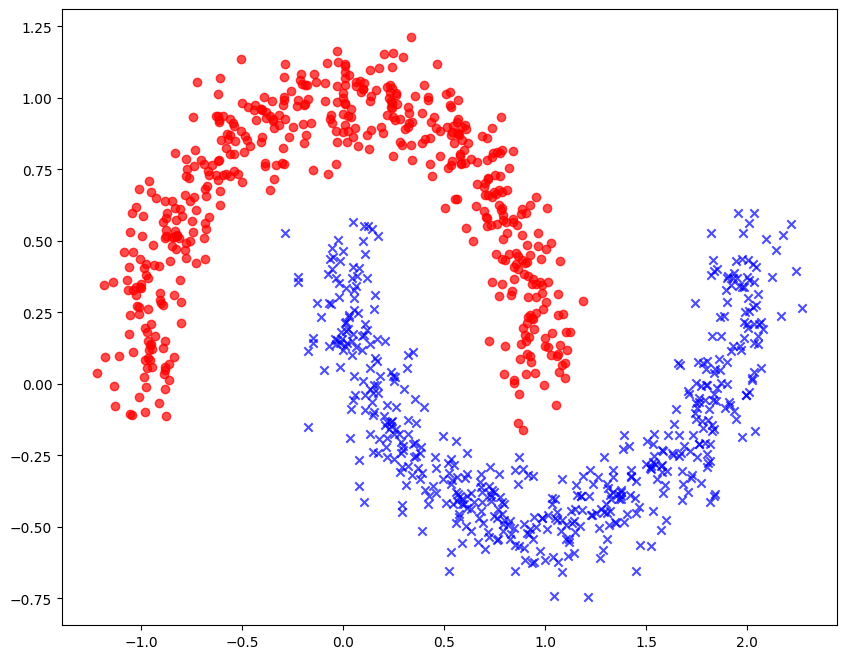

(800, 2) (200, 2) (800, 2) (200, 2)


In [2]:
def generate_data():
    X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)

    plt.figure(figsize=(10, 8))
    plt.scatter(X[y==0][:, 0], X[y==0][:, 1], c='red', marker='o', label='Class 0', alpha=0.7)
    plt.scatter(X[y==1][:, 0], X[y==1][:, 1], c='blue', marker='x', label='Class 1', alpha=0.7)
    plt.show()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    encoder = OneHotEncoder(sparse_output=False)
    y_train_onehot = encoder.fit_transform(y_train)
    y_test_onehot = encoder.transform(y_test)
    return X_train, X_test, y_train_onehot, y_test_onehot

X_train, X_test, y_train, y_test = generate_data()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [3]:
np.random.seed(42)
mlp = MLP(n_inputs=2, n_hidden=[20], n_classes=2)
criteria = CrossEntropy()
test_output = mlp.forward(X_test)
test_loss = criteria.forward(test_output, y_test)
test_accuracy = accuracy(test_output, y_test)
print(f" Loss: {test_loss:4f}, Accuracy: {test_accuracy:4f}")

 Loss: 1.377937, Accuracy: 77.500000


In [4]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

def train(dnn_hidden_units, learning_rate, max_epochs, eval_freq, gd_mode=0, batch_size=32):
  
    mlp = MLP(n_inputs=2, n_hidden=dnn_hidden_units, n_classes=2)
    criteria = CrossEntropy()   
    if(gd_mode == 0): # batch mode
        for epoch in range(max_epochs):
            output = mlp.forward(X_train)
            loss = criteria.forward(output, y_train)
            train_accuracy = accuracy(output, y_train)
            train_losses.append(loss)
            train_accuracies.append(train_accuracy)
            mlp.backward(criteria.backward())
            mlp.update_params(learning_rate)
            print(f"Epoch: {epoch+1}, Train Loss: {loss:.4f}, Train Acc: {train_accuracy:.2f}")
            if epoch % eval_freq == 0 or epoch == max_epochs - 1:
                test_output = mlp.forward(X_test)
                test_loss = criteria.forward(test_output, y_test)
                test_accuracy = accuracy(test_output, y_test)
                test_losses.append(test_loss)
                test_accuracies.append(test_accuracy)
                print(f"Epoch: {epoch+1}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}")
        print("Training complete!")

    elif(gd_mode == 1): # mini-batch mode
        trainloader = DataLoader(X_train, y_train, batch_size=batch_size)
        for epoch in range(max_epochs):
            epoch_train_loss = 0
            epoch_train_accuracy = 0
            batch_count = 0
            for _, (X_batch, y_batch) in enumerate(trainloader):
                output = mlp.forward(X_batch)
                loss = criteria.forward(output, y_batch)
                mlp.backward(criteria.backward())
                mlp.update_params(learning_rate)
                epoch_train_loss += loss
                batch_count += 1
                train_accuracy = accuracy(output, y_batch)
                epoch_train_accuracy += train_accuracy
            avg_train_loss = epoch_train_loss / batch_count
            avg_train_accuracy = epoch_train_accuracy / batch_count
            train_losses.append(avg_train_loss)
            train_accuracies.append(avg_train_accuracy)
            print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.2f}")
            if epoch % eval_freq == 0 or epoch == max_epochs - 1:
                test_output = mlp.forward(X_test)
                test_loss = criteria.forward(test_output, y_test)
                test_accuracy = accuracy(test_output, y_test)
                test_losses.append(test_loss)
                test_accuracies.append(test_accuracy)
                print(f"Epoch: {epoch+1}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}")
        print("Training complete!")

    elif(gd_mode == 2): # SGD
        trainloader = DataLoader(X_train, y_train, batch_size=1)
        for epoch in range(max_epochs):
            epoch_train_loss = 0
            epoch_train_accuracy = 0
            batch_count = 0
            for _, (X_batch, y_batch) in enumerate(trainloader):
                output = mlp.forward(X_batch)
                loss = criteria.forward(output, y_batch)
                mlp.backward(criteria.backward())
                mlp.update_params(learning_rate)
                epoch_train_loss += loss
                batch_count += 1
                train_accuracy = accuracy(output, y_batch)
                epoch_train_accuracy += train_accuracy
            avg_train_loss = epoch_train_loss / batch_count
            avg_train_accuracy = epoch_train_accuracy / batch_count
            train_losses.append(avg_train_loss)
            train_accuracies.append(avg_train_accuracy)
            print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.2f}")
            if epoch % eval_freq == 0 or epoch == max_epochs - 1:
                test_output = mlp.forward(X_test)
                test_loss = criteria.forward(test_output, y_test)
                test_accuracy = accuracy(test_output, y_test)
                test_losses.append(test_loss)
                test_accuracies.append(test_accuracy)
                print(f"Epoch: {epoch+1}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}")
        print("Training complete!")


Trian using BGD

In [5]:
dnn_hidden_units = [20]
learning_rate = 1e-2
max_epochs = 200
eval_freq = 10
gd_mode = 0 # 0 stands for "batch", 1 stands for "mini-batch", and 2 stands for "stochastic".

train(dnn_hidden_units, learning_rate, max_epochs, eval_freq, gd_mode)

Epoch: 1, Train Loss: 5.7162, Train Acc: 49.12
Epoch: 1, Test Loss: 5.6147, Test Acc: 48.00
Epoch: 2, Train Loss: 5.1957, Train Acc: 48.38
Epoch: 3, Train Loss: 4.6971, Train Acc: 47.00
Epoch: 4, Train Loss: 4.2210, Train Acc: 44.25
Epoch: 5, Train Loss: 3.7689, Train Acc: 41.12
Epoch: 6, Train Loss: 3.3416, Train Acc: 39.25
Epoch: 7, Train Loss: 2.9453, Train Acc: 36.75
Epoch: 8, Train Loss: 2.5791, Train Acc: 34.88
Epoch: 9, Train Loss: 2.2476, Train Acc: 33.12
Epoch: 10, Train Loss: 1.9526, Train Acc: 35.38
Epoch: 11, Train Loss: 1.6958, Train Acc: 38.75
Epoch: 11, Test Loss: 1.6756, Test Acc: 37.50
Epoch: 12, Train Loss: 1.4831, Train Acc: 42.00
Epoch: 13, Train Loss: 1.3122, Train Acc: 48.75
Epoch: 14, Train Loss: 1.1772, Train Acc: 52.50
Epoch: 15, Train Loss: 1.0721, Train Acc: 56.38
Epoch: 16, Train Loss: 0.9882, Train Acc: 59.00
Epoch: 17, Train Loss: 0.9209, Train Acc: 62.75
Epoch: 18, Train Loss: 0.8665, Train Acc: 66.50
Epoch: 19, Train Loss: 0.8216, Train Acc: 68.12
Epoch:

/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_3/modules.py:28: RuntimeWarning: divide by zero encountered in matmul
  return x @ self.params['weight'] + self.params['bias']
/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_3/modules.py:28: RuntimeWarning: overflow encountered in matmul
  return x @ self.params['weight'] + self.params['bias']
/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_3/modules.py:28: RuntimeWarning: invalid value encountered in matmul
  return x @ self.params['weight'] + self.params['bias']
/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_3/modules.py:36: RuntimeWarning: divide by zero encountered in matmul
  dw = self.cache['input'].T @ dout
/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_3/modules.py:36: RuntimeWarning: overflow encountered in matmul
  dw = self.cache['input'].T @ dout
/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_3/modules.py:36: RuntimeWarning: invalid value encountered in matm

In [6]:
def plot_loss_and_accuracy(max_epochs, train_losses, train_accuracies, test_losses, test_accuracies):
    epochs = range(1, max_epochs + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, [test_losses[i] if i < len(test_losses) else None for i in range(max_epochs)], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, [test_accuracies[i] if i < len(test_accuracies) else None for i in range(max_epochs)], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Test Accuracy Curve')

    plt.tight_layout()
    plt.show()

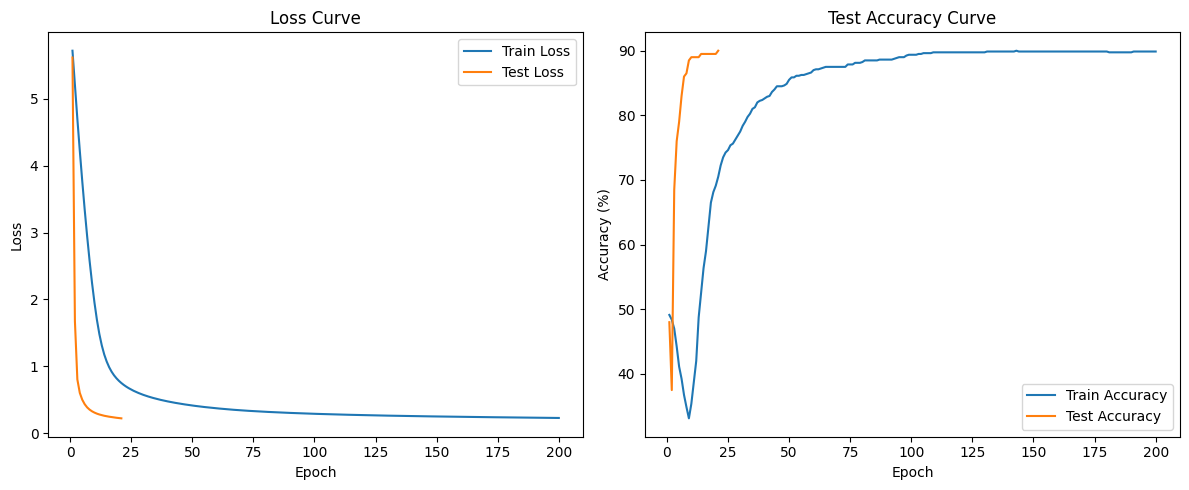

In [7]:
plot_loss_and_accuracy(max_epochs, train_losses, train_accuracies, test_losses, test_accuracies)

Training with MBGD

In [5]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

dnn_hidden_units = [20]
learning_rate = 1e-2
max_epochs = 15
eval_freq = 1
gd_mode = 1 # 0 stands for "batch", 1 stands for "mini-batch", and 2 stands for "stochastic".
batch_size = 32

train(dnn_hidden_units, learning_rate, max_epochs, eval_freq, gd_mode, batch_size)

Epoch: 1, Train Loss: 2.0792, Train Acc: 52.75
Epoch: 1, Test Loss: 0.7219, Test Acc: 72.00
Epoch: 2, Train Loss: 0.5170, Train Acc: 80.62
Epoch: 2, Test Loss: 0.4384, Test Acc: 81.50
Epoch: 3, Train Loss: 0.3700, Train Acc: 87.00
Epoch: 3, Test Loss: 0.3443, Test Acc: 87.50
Epoch: 4, Train Loss: 0.3113, Train Acc: 88.50
Epoch: 4, Test Loss: 0.2975, Test Acc: 90.00
Epoch: 5, Train Loss: 0.2805, Train Acc: 89.88
Epoch: 5, Test Loss: 0.2666, Test Acc: 89.50
Epoch: 6, Train Loss: 0.2609, Train Acc: 89.88
Epoch: 6, Test Loss: 0.2484, Test Acc: 89.50
Epoch: 7, Train Loss: 0.2465, Train Acc: 89.75
Epoch: 7, Test Loss: 0.2346, Test Acc: 89.50
Epoch: 8, Train Loss: 0.2360, Train Acc: 89.88
Epoch: 8, Test Loss: 0.2235, Test Acc: 90.00
Epoch: 9, Train Loss: 0.2263, Train Acc: 89.88
Epoch: 9, Test Loss: 0.2136, Test Acc: 89.50
Epoch: 10, Train Loss: 0.2183, Train Acc: 89.88
Epoch: 10, Test Loss: 0.2041, Test Acc: 90.00
Epoch: 11, Train Loss: 0.2099, Train Acc: 90.00
Epoch: 11, Test Loss: 0.1982, 

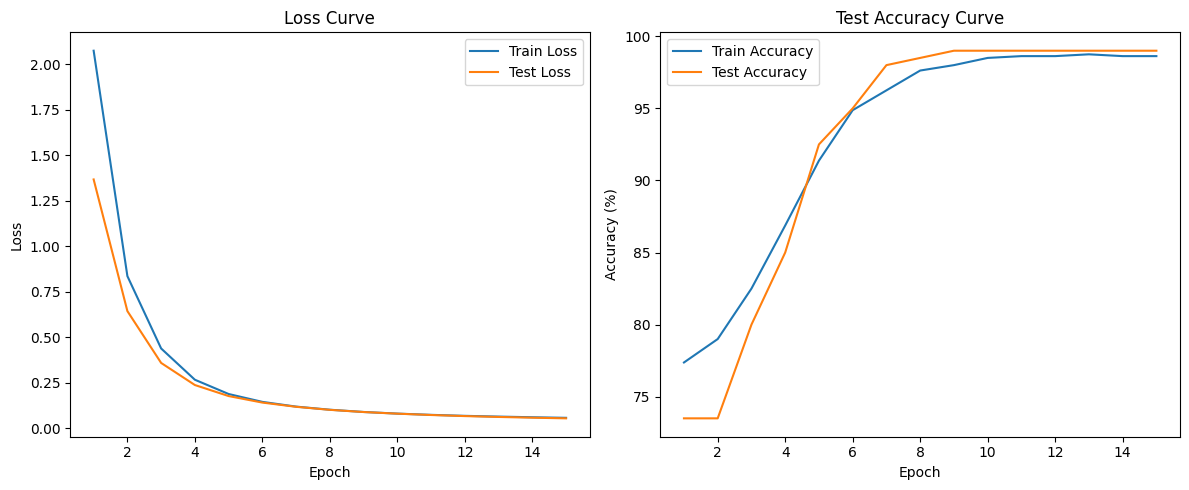

In [9]:
plot_loss_and_accuracy(max_epochs, train_losses, train_accuracies, test_losses, test_accuracies)

Training with SGD

In [10]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

dnn_hidden_units = [20]
learning_rate = 1e-3
max_epochs = 15
eval_freq = 5
gd_mode = 2 # 0 stands for "batch", 1 stands for "mini-batch", and 2 stands for "stochastic".


train(dnn_hidden_units, learning_rate, max_epochs, eval_freq, gd_mode, batch_size)

/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_3/modules.py:28: RuntimeWarning: divide by zero encountered in matmul
  return x @ self.params['weight'] + self.params['bias']
/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_3/modules.py:28: RuntimeWarning: overflow encountered in matmul
  return x @ self.params['weight'] + self.params['bias']
/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_3/modules.py:28: RuntimeWarning: invalid value encountered in matmul
  return x @ self.params['weight'] + self.params['bias']


Epoch: 1, Train Loss: 0.6257, Train Acc: 80.25
Epoch: 1, Test Loss: 0.3872, Test Acc: 87.50
Epoch: 2, Train Loss: 0.3872, Train Acc: 87.00
Epoch: 3, Train Loss: 0.2957, Train Acc: 89.12
Epoch: 4, Train Loss: 0.2427, Train Acc: 90.12


/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_3/modules.py:28: RuntimeWarning: divide by zero encountered in matmul
  return x @ self.params['weight'] + self.params['bias']
/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_3/modules.py:28: RuntimeWarning: overflow encountered in matmul
  return x @ self.params['weight'] + self.params['bias']
/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_3/modules.py:28: RuntimeWarning: invalid value encountered in matmul
  return x @ self.params['weight'] + self.params['bias']


Epoch: 5, Train Loss: 0.2102, Train Acc: 91.25
Epoch: 6, Train Loss: 0.1887, Train Acc: 92.12
Epoch: 6, Test Loss: 0.1713, Test Acc: 92.50
Epoch: 7, Train Loss: 0.1741, Train Acc: 93.50
Epoch: 8, Train Loss: 0.1639, Train Acc: 93.25
Epoch: 9, Train Loss: 0.1536, Train Acc: 94.25
Epoch: 10, Train Loss: 0.1471, Train Acc: 94.75
Epoch: 11, Train Loss: 0.1372, Train Acc: 95.50


/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_3/modules.py:28: RuntimeWarning: divide by zero encountered in matmul
  return x @ self.params['weight'] + self.params['bias']
/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_3/modules.py:28: RuntimeWarning: overflow encountered in matmul
  return x @ self.params['weight'] + self.params['bias']
/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_3/modules.py:28: RuntimeWarning: invalid value encountered in matmul
  return x @ self.params['weight'] + self.params['bias']


Epoch: 11, Test Loss: 0.1321, Test Acc: 93.50
Epoch: 12, Train Loss: 0.1291, Train Acc: 95.62
Epoch: 13, Train Loss: 0.1248, Train Acc: 96.50
Epoch: 14, Train Loss: 0.1186, Train Acc: 96.00
Epoch: 15, Train Loss: 0.1141, Train Acc: 96.00


/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_3/modules.py:28: RuntimeWarning: divide by zero encountered in matmul
  return x @ self.params['weight'] + self.params['bias']
/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_3/modules.py:28: RuntimeWarning: overflow encountered in matmul
  return x @ self.params['weight'] + self.params['bias']
/Users/dove/Desktop/DeepLearning/12410106_assignment1/Part_3/modules.py:28: RuntimeWarning: invalid value encountered in matmul
  return x @ self.params['weight'] + self.params['bias']


Epoch: 15, Test Loss: 0.1087, Test Acc: 96.50
Training complete!


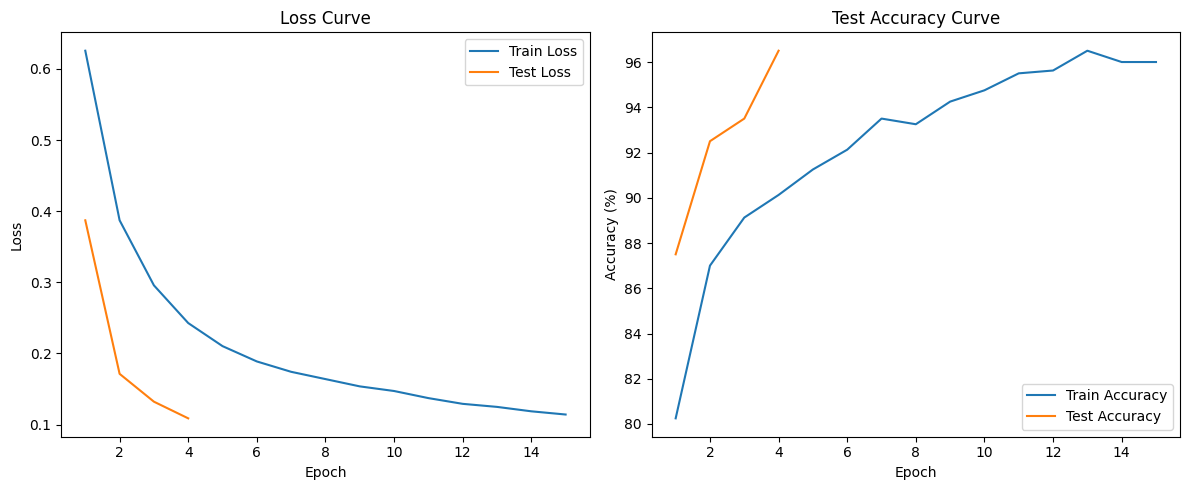

In [11]:
plot_loss_and_accuracy(max_epochs, train_losses, train_accuracies, test_losses, test_accuracies)

## Analysis of batchsize

Batch Gradient Descent (BGD) use all training examples as a batch, while mini-batch gradient descent uses a subset of training examples as a batch and Stochastic Gradient Descent (SGD) uses only one training example as a batch.When we decrease the batch size, our experiments can easily show that the model will converge faster, but probably more unstable. If you run the notebook multiple times, you will see that BGD leads to similar loss and acc curves, while mini-batch and SGD can be very different each time. This is because BGD use the whole dataset to learn the model, but mini-batch gradient descent randomly samples a subset to approximate the whole data distribution, and SGD iterates over a single example which add even more noice.Adding noice to training process may result in difficulty in converging, but it can also help to avoid overfitting and improve the model's generalization ability.